# Imports

In [83]:
#Standard Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import warnings
warnings.filterwarnings(action='ignore') 

# Packages used for API calls and data processing
import requests
import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)
import ast
import time
import http.client, urllib.request, urllib.parse, urllib.error, base64
api_key = 'ceeaacb7cf024c7485e00ef8457e42dc'
gamertag = 'Drymander'
from tqdm import tqdm
# !pip install isodate
import isodate

In [265]:
# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder


In [167]:
# Prepare gamertag for API
def gamertag_for_api(gamertag):
    
    # Replace spaces with '+'
    gamertag = gamertag.replace(' ','+')
    return gamertag

# Testing the function
gamertag_for_api('this is a test')

'this+is+a+test'

In [172]:
# Function to pull most recent match stats into JSON format
# Uses two separate API calls, one from player history and another from match details
def pull_recent_match(how_recent, api_key=api_key, explore=False, gamertag='Drymander'):
    
    # Use gamertag_for_api function to remove any spaces
    gamertag = gamertag_for_api(gamertag)
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    # Pulls from arena mode, how_recent is how far to go back in the match history
    # 'count' refers to the number of matches to pull
    params = urllib.parse.urlencode({
        # Request parameters
        'modes': 'arena',
        'start': how_recent,
        'count': 1,
        'include-times': True,
    })
    
    # Try this, otherwise return error message
    try:
        
        # Connect to API and pull most recent match for specified gamer
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", f"/stats/h5/players/{gamertag}/matches?%s" % params, "{body}", headers)
        response = conn.getresponse()
        latest_match = json.loads(response.read())
        
        # Identify match ID and match date
        match_id = latest_match['Results'][0]['Id']['MatchId']
        match_date = latest_match['Results'][0]['MatchCompletedDate']['ISO8601Date']
        
        # Rest for 1.01 seconds to not get blocked by API
        time.sleep(1.01)
        
        # Using match_id, pull details from match
        conn.request("GET", f"/stats/h5/arena/matches/{match_id}?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        
        # Option to return as byte string for alternative viewing
        if explore == True:
            print(data)
        else:
            # Append match ID and date from player history API call
            match_results = json.loads(data)
            match_results['MatchId'] = match_id
            match_results['Date'] = match_date
        conn.close()
    
    # Print error if issue with calling API
    except Exception as e:
        print(f"[Errno {0}] {1}".format(e.errno, e.strerror))
    
    # Return match results as JSON
    return match_results

# Show result
match_results = pull_recent_match(0, explore=False, gamertag='Drymander')
match_results

{'PlayerStats': [{'XpInfo': {'PrevSpartanRank': 138,
    'SpartanRank': 138,
    'PrevTotalXP': 6187181,
    'TotalXP': 6189035,
    'SpartanRankMatchXPScalar': 2.238,
    'PlayerTimePerformanceXPAward': 529,
    'PerformanceXP': 99,
    'PlayerRankXPAward': 200,
    'BoostAmount': 0,
    'MatchSpeedWinAmount': 0,
    'ObjectivesCompletedAmount': 0},
   'PreviousCsr': None,
   'CurrentCsr': None,
   'MeasurementMatchesLeft': 10,
   'RewardSets': [],
   'KilledOpponentDetails': [{'GamerTag': 'Drymander', 'TotalKills': 6},
    {'GamerTag': 'SixKnifeWalker', 'TotalKills': 8},
    {'GamerTag': 'Bophodes', 'TotalKills': 5},
    {'GamerTag': 'cryptolockerSD', 'TotalKills': 1}],
   'KilledByOpponentDetails': [{'GamerTag': 'Bophodes', 'TotalKills': 4},
    {'GamerTag': 'Drymander', 'TotalKills': 1},
    {'GamerTag': 'SixKnifeWalker', 'TotalKills': 5},
    {'GamerTag': 'cryptolockerSD', 'TotalKills': 2}],
   'FlexibleStats': {'MedalStatCounts': [],
    'ImpulseStatCounts': [{'Id': 'ba327946-418

In [169]:
# Function to build the base dataframe for a single match
# Designed to take in the JSON provided by the pull_recent_match function
def build_base_dataframe(match_results, gamertag):
    
    # Build empty base match dataframe
    df = pd.DataFrame()
    columns = [
        'Finished'
        'TeamId',
        'Gamertag',
        'SpartanRank',
        'PrevTotalXP',
    ]
    df = pd.DataFrame(columns = columns)
    
    # Populate base match dataframe with player stats for each player
    i = 0
    for player in match_results['PlayerStats']:

        player_dic = {}
        # Team ID
        player_dic['DNF'] = match_results['PlayerStats'][i]['DNF']
        player_dic['TeamId'] = match_results['PlayerStats'][i]['TeamId']
        # Team Color
        player_dic['TeamColor'] = match_results['PlayerStats'][i]['TeamId']
        # Gamer Tag
        player_dic['Gamertag'] = match_results['PlayerStats'][i]['Player']['Gamertag']
        # Spartan Rank
        player_dic['SpartanRank'] = match_results['PlayerStats'][i]['XpInfo']['SpartanRank']
        # Previous Total XP
        player_dic['PrevTotalXP'] = match_results['PlayerStats'][i]['XpInfo']['PrevTotalXP']
        df = df.append(player_dic, ignore_index=True)
        i += 1
    
    ########## DATE, GAME VARIANT, MAP ID, MATCH ID, PLAYLIST ID ##########
    df['Date'] = match_results['Date']
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_convert(None)
#     df['Date'] = df['Date'].floor('T')
    df['MatchId'] = match_results['MatchId']
    df['GameBaseVariantId'] = match_results['GameBaseVariantId']
    df['MapVariantId'] = match_results['MapVariantId']
    df['PlaylistId'] = match_results['PlaylistId']
    
    ########## DEFINE PLAYER TEAM ##########
    playerteam = df.loc[df['Gamertag'] == gamertag, 'TeamId'].values[0]
    if playerteam == 0:
        enemyteam = 1   
    else:
        enemyteam = 0
        
    df['PlayerTeam'] = df['TeamId'].map({playerteam:'Player', enemyteam:'Enemy'})
    
    if match_results['TeamStats'][0]['TeamId'] == playerteam:
        playerteam_stats = match_results['TeamStats'][0]
        enemyteam_stats = match_results['TeamStats'][1]
    else: 
        playerteam_stats = match_results['TeamStats'][1]
        enemyteam_stats = match_results['TeamStats'][0]
    
    ########## DETERMINE WINNER ##########
    # Tie
    if playerteam_stats['Rank'] == 1 and enemyteam_stats['Rank'] == 1:
        df['Winner'] = 'Tie'
    # Player wins
    elif playerteam_stats['Rank'] == 1 and enemyteam_stats['Rank'] == 2:
        df['Winner'] = df['TeamId'].map({playerteam:'Victory', enemyteam:'Defeat'})
    # Enemy wins
    elif playerteam_stats['Rank'] == 2 and enemyteam_stats['Rank'] == 1:
        df['Winner'] = df['TeamId'].map({enemyteam:'Victory', playerteam:'Defeat'})
    # Error handling
    else:
        winner = 'Error determining winner'
    
    ########## TEAM COLOR ##########
    df['TeamColor'] = df['TeamId'].map({0:'Red', 1:'Blue'})
    
    # Set columns
    df = df[['Date', 'MatchId', 'GameBaseVariantId', 'PlaylistId', 'MapVariantId', 'DNF',
             'TeamId', 'PlayerTeam', 'Winner', 'TeamColor', 
             'Gamertag', 'SpartanRank', 'PrevTotalXP',
            ]]
    # Sort match by winning team
    df = df.sort_values(by=['Winner'], ascending=False)
    
    return df

df = build_base_dataframe(pull_recent_match(8), 'Drymander')

df

Date                               MatchId  \
1 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
2 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
3 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
4 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
8 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
0 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
5 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
6 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   
7 2021-07-22 19:57:51.588  829493b0-9eb4-4c07-a0b1-e5c7d2c33159   

                      GameBaseVariantId                            PlaylistId  \
1  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
2  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
3  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
4  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
8  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
0  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
5  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
6  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
7  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   

                           MapVariantId  DNF  TeamId PlayerTeam   Winner  \
1  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     1.0     Player  Victory   
2  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     1.0     Player  Victory   
3  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  1.0     1.0     Player  Victory   
4  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     1.0     Player  Victory   
8  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     1.0     Player  Victory   
0  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     0.0      Enemy   Defeat   
5  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     0.0      Enemy   Defeat   
6  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     0.0      Enemy   Defeat   
7  e669aabf-1a6f-4b77-b79c-e9c03a1fbb54  0.0     0.0      Enemy   Defeat   

  TeamColor         Gamertag SpartanRank PrevTotalXP  
1      Blue         er0sking         150    33709649  
2      Blue      ANuNNaKI Vs          50      844650  
3      Blue  S H I N I N MEX          49      792836  
4      Blue        Drymander         148    15522876  
8      Blue    CDAxXB4RD0KXx          94     2862704  
0       Red  LiLmeFromDaFutr         150    27622353  
5       Red     JubiPrincess          75     1869267  
6       Red       maneth 007         146    10332365  
7       Red  BeardedDirdMirm         150    33032060

In [170]:
# Function to combine all gamertags from the match and prepare them in string
# format for the next API call
def get_player_list(df):
    
    # Create list from our df['Gamertag'] column and remove the brackets
    player_list = str(list(df['Gamertag']))[1:-1]
    
    # Format string for API
    player_list = player_list.replace(', ',',')
    player_list = player_list.replace("'",'')
    player_list = player_list.replace(' ','+')
    
    # Return in one full string
    return player_list

get_player_list(df)

'er0sking,ANuNNaKI+Vs,S+H+I+N+I+N+MEX,Drymander,CDAxXB4RD0KXx,LiLmeFromDaFutr,JubiPrincess,maneth+007,BeardedDirdMirm'

In [171]:
# Function to pull more informative information about each player in the match
# This information is not available in the two previous API calls
def get_player_history(df, readable=False):
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': str(api_key),
    }
    params = urllib.parse.urlencode({
    })
    # Use our function in the block above the prepare the gamertags for the API
    player_list_api = get_player_list(df)
    
    # Try calling service records API using our player list
    try:
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", f"/stats/h5/servicerecords/arena?players={player_list_api}&%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = response.read()
        player_history = json.loads(data)
        conn.close()
    
    # Return error if issue with API
    except Exception as e:
        print(f"[Errno {0}] {1}".format(e.errno, e.strerror))
    
    # Option to view in byte string readable format
    if readable == False:
        return player_history
    else:
        return data

# Show result
player_history = get_player_history(df)
player_history

{'Results': [{'Id': 'er0sking',
   'ResultCode': 0,
   'Result': {'ArenaStats': {'ArenaPlaylistStats': [],
     'HighestCsrAttained': {'Tier': 5,
      'DesignationId': 4,
      'Csr': 0,
      'PercentToNextTier': 0,
      'Rank': None},
     'ArenaGameBaseVariantStats': [{'FlexibleStats': {'MedalStatCounts': [{'Id': '2b151d0f-cde6-4471-9f1d-d0f8e8644471',
          'Count': 205},
         {'Id': 'f0d50d01-6197-4d0d-a3a5-a86110997e40', 'Count': 100},
         {'Id': 'dcd5ff64-4b49-4020-96d0-88ba3fb28a56', 'Count': 125},
         {'Id': '74365be9-d515-4229-9561-bfaac5bab089', 'Count': 113}],
        'ImpulseStatCounts': [{'Id': 'ba327946-418c-495d-90c0-89f084bf7447',
          'Count': 542},
         {'Id': '7dcd7306-f905-401a-97f2-345d4b25170a', 'Count': 209},
         {'Id': 'ea38d25f-d887-4bdf-b17b-8e8e649b9a87', 'Count': 405},
         {'Id': '780104cb-5b86-4ed9-8fb1-40b919de0766', 'Count': 28}],
        'MedalTimelapses': [],
        'ImpulseTimelapses': [{'Id': 'f1c317ee-1ac4-408

In [175]:
# Function to build secondary dataframe with more informative player stats
def build_history_dataframe(player_history, variant_id, streamlit=False):
    
    # Option to view 'streamlit' dataframe, which includes pertinent
    # information but excludes all stats for modeling
    if streamlit == True:
        vdf_columns = ['Gamertag','TotalTimePlayed','K/D','Accuracy','WinRate']
        vdf = pd.DataFrame(columns = vdf_columns)
    else:
        stat_list = ['Gamertag', 'TotalKills', 'TotalHeadshots', 'TotalWeaponDamage', 'TotalShotsFired',
                    'TotalShotsLanded', 'TotalMeleeKills', 'TotalMeleeDamage', 'TotalAssassinations',
                    'TotalGroundPoundKills', 'TotalGroundPoundDamage', 'TotalShoulderBashKills',
                    'TotalShoulderBashDamage', 'TotalGrenadeDamage', 'TotalPowerWeaponKills',
                    'TotalPowerWeaponDamage', 'TotalPowerWeaponGrabs', 'TotalPowerWeaponPossessionTime',
                    'TotalDeaths', 'TotalAssists', 'TotalGamesCompleted', 'TotalGamesWon',
                    'TotalGamesLost', 'TotalGamesTied', 'TotalTimePlayed','TotalGrenadeKills']
        vdf = pd.DataFrame(columns = stat_list)
    
    # Set coutner variable
    i = 0
    # Loop the goes through each player in the player history JSON
    for player in player_history['Results']:
        
        # Loop that goes through each Arena Game Base Variant and locates
        # the details specific to the game vase variant of the match
        for variant in player['Result']['ArenaStats']['ArenaGameBaseVariantStats']:
            if variant['GameBaseVariantId'] == variant_id:
                variant_stats = variant
        
        # Create empty dictionary where stats will be added
        variant_dic = {}
        
        # Streamlit option - calculates specifc features
        if streamlit == True:
            variant_dic['Gamertag'] = player_history['Results'][i]['Id']
            variant_dic['TotalTimePlayed']= isodate.parse_duration(variant_stats['TotalTimePlayed']).total_seconds() / 3600
            variant_dic['K/D'] = variant_stats['TotalKills'] / variant_stats['TotalDeaths']
            variant_dic['Accuracy'] = variant_stats['TotalShotsLanded'] / variant_stats['TotalShotsFired']
            variant_dic['WinRate'] = variant_stats['TotalGamesWon'] / variant_stats['TotalGamesLost']
            vdf = vdf.append(variant_dic, True)
            i += 1
        
        # Modeling option - includes all features but does not yet calculate
        else:
            variant_dic['Gamertag'] = player_history['Results'][i]['Id']
            
            # Loop that appends all stats to variant dic
            for stat in stat_list[1:]:    
                variant_dic[stat] = variant_stats[stat]
            
            # Parsing ISO duration times
            variant_dic['TotalTimePlayed']= isodate.parse_duration(variant_stats['TotalTimePlayed']).total_seconds() / 3600
            vdf = vdf.append(variant_dic, True)
            i += 1
    
    # Return the streamlit or modeling dataframe
    return vdf
    
build_history_dataframe(player_history, '1571fdac-e0b4-4ebc-a73a-6e13001b71d3', streamlit=False)

Gamertag TotalKills TotalHeadshots  TotalWeaponDamage  \
0         er0sking        542            234       62859.783547   
1      ANuNNaKI Vs        324             52       43548.503118   
2  S H I N I N MEX         95             21       10633.469292   
3        Drymander       2551            137      316416.816237   
4    CDAxXB4RD0KXx        344             48       42686.739529   
5  LiLmeFromDaFutr        642            121       83976.926171   
6     JubiPrincess         57              4        6880.550871   
7       maneth 007        982             86      124854.242591   
8  BeardedDirdMirm       2440            282      315338.029387   

  TotalShotsFired TotalShotsLanded TotalMeleeKills  TotalMeleeDamage  \
0           10842             4737              37       4765.384587   
1            8089             2809              13       1537.806410   
2            2103              898              20       2147.748150   
3           60129            20832             126      15502.626122   
4            6803             2418              19       2672.913459   
5           16596             7076              44       8292.677700   
6             865              334               0        368.500008   
7           26179             8609              61       8004.927242   
8           50893            18587             159      19027.618741   

  TotalAssassinations TotalGroundPoundKills  ...  TotalPowerWeaponGrabs  \
0                   4                     3  ...                     21   
1                   2                     0  ...                      0   
2                   6                     0  ...                      1   
3                  25                     2  ...                      2   
4                   4                     3  ...                      0   
5                   7                     3  ...                      3   
6                   1                     0  ...                      0   
7                  15                     4  ...                      2   
8                  24                    21  ...                     10   

  TotalPowerWeaponPossessionTime  TotalDeaths  TotalAssists  \
0                  PT13M33.9836S          405           209   
1                 PT1H41M9.4011S          272            78   
2                      PT7M55.3S           96            19   
3               PT16H36M29.8987S         2852           487   
4                PT2H12M42.6507S          312            79   
5                PT1H46M57.8161S          557           228   
6                  PT22M58.9164S          103            12   
7                PT5H20M47.6851S         1082           288   
8               PT12H15M39.9151S         2263           612   

  TotalGamesCompleted  TotalGamesWon TotalGamesLost TotalGamesTied  \
0                  47             19             28              0   
1                  27             11             16              0   
2                  10              4              6              0   
3                 250            148            102              0   
4                  36             14             22              0   
5                  66             42             24              0   
6                  17              8              9              0   
7                 110             55             55              0   
8                 248            128            120              0   

  TotalTimePlayed TotalGrenadeKills  
0        5.084146                44  
1        3.228458                10  
2        1.130857                 6  
3       28.649340                49  
4        3.700031                 6  
5        6.984896                46  
6        1.672351                 1  
7       11.891076                32  
8       27.166478               138  

[9 rows x 26 columns]

In [176]:
# Function that combines all functions above to go through each step to
# Get the match dataframe
def recent_match_stats(gamertag, back_count=0):
    
    # Pull the match result as JSON from API
    match_results = pull_recent_match(back_count, explore=False, gamertag=gamertag)
    
    # Build the base dataframe
    base_df = build_base_dataframe(match_results, gamertag=gamertag)
    
    # Sleep for 1.01 seconds to avoid issues with API
    time.sleep(1.01)
    
    # Create playerlist for player history API call
    player_list = get_player_list(base_df)
    
    # Call API to get player history JSON
    player_history = get_player_history(base_df)
    
    # Build base player stats dataframe based on player history API call
    history_df = build_history_dataframe(player_history, match_results['GameBaseVariantId'])
    
    # Merge the base dataframe and stats dataframe
    full_stats_df = pd.merge(base_df, history_df, how='inner', on = 'Gamertag')
    
    return full_stats_df

# Show full dataframe for match
df = recent_match_stats('Drymander', back_count=0)
df

Date                               MatchId  \
0 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
1 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
2 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
3 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
4 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
5 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
6 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   
7 2021-07-22 21:00:59.258  2eecaf00-ba9f-432e-b144-bc1c90b29430   

                      GameBaseVariantId                            PlaylistId  \
0  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
1  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
2  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
3  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
4  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
5  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
6  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
7  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   

                           MapVariantId  DNF  TeamId PlayerTeam   Winner  \
0  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     0.0      Enemy  Victory   
1  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     0.0      Enemy  Victory   
2  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     0.0      Enemy  Victory   
3  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     0.0      Enemy  Victory   
4  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     1.0     Player   Defeat   
5  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     1.0     Player   Defeat   
6  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     1.0     Player   Defeat   
7  6b306cc8-1d60-41ae-9e95-464fdbe1288b  0.0     1.0     Player   Defeat   

  TeamColor  ... TotalPowerWeaponGrabs TotalPowerWeaponPossessionTime  \
0       Red  ...                   456              P1DT23H19M2.7727S   
1       Red  ...                   520              P2DT8H12M46.2633S   
2       Red  ...                    16                P5DT4H46M4.712S   
3       Red  ...                   124              P2DT12H2M20.8034S   
4      Blue  ...                   140              P7DT14H34M15.173S   
5      Blue  ...                   691            P10DT16H56M12.3383S   
6      Blue  ...                    86             P8DT14H20M21.7446S   
7      Blue  ...                 10647                P19DT49M9.3166S   

  TotalDeaths TotalAssists TotalGamesCompleted  TotalGamesWon TotalGamesLost  \
0       18249         4062                1545            721            824   
1       20930         4852                1726            803            923   
2       18256         3727                1482            729            752   
3       14490         4623                1367            655            711   
4       27853         5890                2510           1252           1258   
5       48903        15343                4869           2569           2299   
6       35472        10024                3040           1453           1586   
7      170284        58474               15008           7445           7553   

  TotalGamesTied TotalTimePlayed  TotalGrenadeKills  
0              0      177.035887                515  
1              0      195.564511                758  
2              1      193.407282                211  
3              1      164.625542                737  
4              0      297.931417                452  
5              1      559.083225               2745  
6              1      393.653111               1144  
7             10     2011.164532              16795  

[8 rows x 38 columns]

In [181]:
# Function to convert the full match dataframe into a single Pandas row for modeling
def one_row(df, for_model=False):
    
    # If statement that rules out matches that will present issues for the model
    # We want to make sure that exactly 8 players finished teh match and that
    # No player exited the game before it was over
    if ((for_model==True) and ((len(df.index) != 8) or (1 in df['DNF'].values))):
        # Returns an empty dataframe that will be appended to the modeling dataset,
        # effectively denoting that the match will not be usable for the model
        df = pd.DataFrame()
    
    # If the match meets the modeling criteria:
    else:
        # Sort by PlayerTeam (captures player team stats first)
        # Sort by TotalTimePlayed
        df = df.sort_values(by=['PlayerTeam', 'TotalTimePlayed'], ascending=(False, False))
        
        # Isolate portion of the dataframe for creating information we need
        df = df.reset_index()
        df_row = df.iloc[0:1,1:6]
        
        # Determine whether player won, lost, or tied the match
        df_player = df.loc[df['PlayerTeam'] == 'Player']
        if df_player['Winner'].str.contains('Victory').any():
            df_row['WinLoseTie'] = 'Victory'
        elif df_player['Winner'].str.contains('Defeat').any():
            df_row['WinLoseTie'] = 'Defeat'
        elif df_player['Winner'].str.contains('Tie').any():
            df_row['WinLoseTie'] = 'Tie'
        else: 
            df_row['WinLoseTie'] = 'Error Determining Victor'
        
        # 'Flatten' the match dataframe so that each player stat can
        # be represented in one line of data
        column_list = df.columns.to_list()
        columns_converted = []
        df = df.drop(df.iloc[:, 0:11], axis = 1)
        df = df.stack().to_frame().T
        df.columns = ['{}_{}'.format(*c) for c in df.columns]
        
        # Dictionary to convert strings denoting P1-4 (Player 1-4), E1 (Enemey 1-4)
        column_convert_dic = {"0_":"P1-", "1_":"P2-","2_":"P3-","3_":"P4-",
                              "4_":"E1-","5_":"E2-","6_":"E3-","7_":"E4-",}

        # Use dictionary to set column names
        for k, v in column_convert_dic.items():
            df.columns = df.columns.str.replace(k, v)
        df.columns = df.columns.str.replace('-', '_')
        df = df_row.join(df, how='outer')
    
    # Return match dataframe as one row
    return df

# Test function
one_row(df, for_model=False)

Date                               MatchId  \
0 2021-07-22 20:10:56.747  ba5f5693-099e-4734-8f37-14cb4de0bfad   

                      GameBaseVariantId                            PlaylistId  \
0  a2949322-dc84-45ab-8454-cf94fb28c189  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   

                           MapVariantId WinLoseTie P1_Gamertag P1_SpartanRank  \
0  3099f1e3-c911-4620-9bec-73db7cec6b7c    Victory  VotedBug44            152   

  P1_PrevTotalXP P1_TotalKills  ... E4_TotalPowerWeaponGrabs  \
0       51368056         53165  ...                        1   

  E4_TotalPowerWeaponPossessionTime E4_TotalDeaths E4_TotalAssists  \
0                   PT1H13M11.1503S            252             147   

  E4_TotalGamesCompleted E4_TotalGamesWon E4_TotalGamesLost E4_TotalGamesTied  \
0                     29               13                15                 1   

  E4_TotalTimePlayed E4_TotalGrenadeKills  
0            2.70447                   12  

[1 rows x 230 columns]

In [183]:
# Load unique gamertags pickle file from EDA notebook

with open('unique_gamertags.pkl', 'rb') as unique_gamertags_pickle:
    unique_gamertags = pickle.load(unique_gamertags_pickle)

# See how many unique gamertags that the player has played with
len(unique_gamertags)

24248

In [185]:
# Function that slightly models the pull_recent_match function
# Designed to pull 25 matches from each gamertag for modeling
def model_pull_matches(how_recent, api_key=api_key, 
                       gamertag='Drymander', count=25):
    
    # Use gamertag_for_api function to remove any spaces
    gamertag = gamertag_for_api(gamertag)
    # Set API key
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    
    # Pulls from arena mode, how_recent is how far to go back in the match history
    # 'count' refers to the number of matches to pull
    params = urllib.parse.urlencode({
        # Request parameters
        'modes': 'arena',
        'start': 0,
        'count': count,
        'include-times': True,
    })
    
    # Try / except for error handling
    try:
        
        # Connect to API and pull most recent 25 matches for specified gamer
        # and format into JSON
        conn = http.client.HTTPSConnection('www.haloapi.com')
        conn.request("GET", f"/stats/h5/players/{gamertag}/matches?%s" % params, "{body}", headers)
        time.sleep(1.01)
        response = conn.getresponse()
        data = response.read()
        history_pull = json.loads(data)
        print(history_pull['ResultCount'])
        
        # Counter variable for printing status
        i = 0
        
        # Empty list to append 25 matches
        latest_count_matches = []
        
        # Loop to go through each of the 25 matches to pull match details for each
        for match in history_pull['Results']:
            
            # Identify match ID and match date
            match_id = match['Id']['MatchId']
            match_date = match['MatchCompletedDate']['ISO8601Date']
            
            # API call for each match ID in teh 25 matches
            conn.request("GET", f"/stats/h5/arena/matches/{match_id}?%s" % params, "{body}", headers)
            time.sleep(1.1)
            
            # Format into JSON and append match ID and date
            response = conn.getresponse()
            data = response.read()
            match_results = json.loads(data)
            match_results['MatchId'] = match_id
            match_results['Date'] = match_date
            
            # Append each match JSON to full list
            latest_count_matches.append(match_results)
            conn.close()
            i += 1
            
            # Print total number of matches appended to list
            print(f'{i} matches appended')
    
    # Error handling
    except Exception as e:
        print(f"[Errno {0}] {1}".format(e.errno, e.strerror))
    
    # Return full set of 25 matches
    return latest_count_matches

# Testing the function
latest_count_matches = model_pull_matches(0, gamertag='Drymander', count=5)

5
1 matches appended
2 matches appended
3 matches appended
4 matches appended
5 matches appended


In [184]:
# Setting run to false
# If set to true, model will start adding new rows to model datafarme stored in .csv
run = False

# Isolating portion of unique_gamertags to build model dataframe in manageable chunks
gamertag_list = unique_gamertags[651:850]

# Function add rows to the modeling dataframe
def model_recent_match_stats(gamertag_list, back_count=0, count=25):
    
    # Create new dataframe
    df = pd.DataFrame()
    
    # Set gamertag_count to zero, will be used in updating status via print
    gamertag_count = 0
    
    # Loop through gamertags in unique_gamertags list
    for gamertag in tqdm(gamertag_list):
        
        # Try / except to deal with API error handling
        try:
            # Use latest_count_match function to pull 25 matches from player 
            latest_count_matches = model_pull_matches(0, gamertag=gamertag, count=count)
            time.sleep(1.1)
            
            # Setting error counter and additional counter variable
            error_count = 0
            i = 0
            
            # Loop through each of the players 25 matches
            for match in latest_count_matches:
                
                # Error handling
                try:
                    
                    # Build the base dataframe
                    base_df = build_base_dataframe(match, gamertag=gamertag)
                    
                    # Create playerlist for player history API call
                    player_list = get_player_list(base_df)
                    
                    # Call API to get player history JSON
                    player_history = get_player_history(base_df)
                    
                    # Build base player stats dataframe based on player history API call
                    history_df = build_history_dataframe(player_history, match_results['GameBaseVariantId'])
                    
                    # Merge the base dataframe and stats dataframe
                    full_stats_df = pd.merge(base_df, history_df, how='inner', on = 'Gamertag')
                    
                    # Flatten full match dataframe into one row, 
                    row = one_row(full_stats_df, for_model=True)
                    
                    # Append row to model dataframe .csv with specific date format  
                    row.to_csv('MODEL_PULL.csv', mode ='a', date_format='%Y-%m-%d %H:%M:%S', header=False)
                    
                    # Append to model dataframe if working outside of .csv
                    df = df.append(row)
                    
                    # Print how many rows have been added to the dataframe
                    i += 1
                    print(f'{i} rows added to model dataframe')

                    time.sleep(1.1)
                except:
                    
                    # Print error count if row cannot be added because it doesn't meet criteria
                    # Typically this occurs when a player has changed their gamertag
                    error_count += 1
                    print(f'{error_count} rows returned error when getting player history')
                    time.sleep(1.1)
                    error_count += 1
                    continue
            
            # Print number of gamertags that the function has gone through
            gamertag_count += 1
            print(f'{gamertag_count} completed')
        
        except:
            
            # Show error message if gamer skipped due to name change or other issue with API
            print('gamertag skipped due to error')
    
    # Return modeling dataframe
    return df

if run == True:
    model_df = model_recent_match_stats(gamertag_list, back_count=0, count=25)
else:
    pass


# Load Model Dataframe from CSV

In [211]:
# Load csv created by model_recent_match_stats
df = pd.read_csv('MODEL_PULL.csv')

# Convert the dates to datetime objects
df['Date'] = df['Date'].apply(pd.to_datetime)

# Drop 'Unnamed: 0' from dataframe
df = df.drop(['Unnamed: 0'], axis=1)

# Remove null, infinity, and negative infinity
# This can cause errors when creating features
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

df.head(3)

Date                               MatchId  \
0 2021-07-17 21:39:00  1bc32b01-2dda-418a-8853-ba3d3b09f912   
1 2021-07-19 00:29:00  06c5149f-72af-4678-9615-7d2db89db290   
2 2021-07-19 00:25:00  7801d2b0-f941-4851-9b04-8208a5439497   

                      GameBaseVariantId                            PlaylistId  \
0  257a305e-4dd3-41f1-9824-dfe7e8bd59e1  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
1  a2949322-dc84-45ab-8454-cf94fb28c189  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   
2  a2949322-dc84-45ab-8454-cf94fb28c189  f0c9ef9a-48bd-4b24-9db3-2c76b4e23450   

                           MapVariantId WinLoseTie    P1_Gamertag  \
0  d5f2d94f-b51f-4a0c-8c35-af99426bf14d     Defeat  TED Cloverlan   
1  7a4ca104-7242-4efe-a53e-fb5295d7b092    Victory      Drymander   
2  d0a6c435-a5df-465f-b728-0547dea06c3c    Victory    TWINKYNECKS   

   P1_SpartanRank  P1_PrevTotalXP  P1_TotalKills  ...  \
0             102         3348130           3378  ...   
1             148        15348257          39273  ...   
2             151        37161347          58661  ...   

   E4_TotalPowerWeaponGrabs  E4_TotalPowerWeaponPossessionTime  \
0                        18                    PT2H59M39.6153S   
1                        31                    PT1H50M55.1666S   
2                         0                    PT6H28M57.5337S   

   E4_TotalDeaths  E4_TotalAssists  E4_TotalGamesCompleted  E4_TotalGamesWon  \
0            1089              445                     107                52   
1            1227              559                     105                35   
2            1603              853                     117                49   

   E4_TotalGamesLost  E4_TotalGamesTied  E4_TotalTimePlayed  \
0                 48                  7           11.855415   
1                 65                  5           12.014393   
2                 48                 20           12.392531   

   E4_TotalGrenadeKills  
0                    43  
1                    11  
2                    40  

[3 rows x 230 columns]

In [212]:
# Define roster to interact with dataframe
roster = ['P1', 'P2', 'P3', 'P4', 'E1', 'E2', 'E3', 'E4']

# Loop through players in roster
for player in roster:
    
    # Empty list of parsed times
    parsed_times = []
    
    # Parse times for each player 
    for row in df[f'{player}_TotalPowerWeaponPossessionTime']:
        row = isodate.parse_duration(row).total_seconds() / 3600
        parsed_times.append(row)
    
    # Set column to parsed times list
    df[f'{player}_TotalPowerWeaponPossessionTime'] = parsed_times

df['P1_TotalPowerWeaponPossessionTime']

0         14.334023
1        157.602300
2        215.471346
3        346.243585
4        157.602300
            ...    
12243    180.672707
12244    234.343814
12245    154.076870
12246     89.332089
12247     69.650356
Name: P1_TotalPowerWeaponPossessionTime, Length: 12236, dtype: float64

In [213]:
# This function will convert codes provided by the API into a readable format
def decode_column(df, column, api_dict):
    
    # Empty list of decoded values
    decoded_list = []
    
    # Loop through each row
    for row in df[column]:
        i = 0
        
        # Loop through API dictionary
        for item in api_dict:
            
            # If code found, append it to list
            if item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            
            # Otherwise keep searching until found
            else:
                i += 1
    
    # Return decoded list
    return decoded_list

In [214]:
# This function will convert maps to readable format
def decode_maps(df, column, api_dict):
    decoded_list = []
    
    # Loop through each row
    for row in df[column]:
        i = 0
        
        # Creating map_count variable
        map_count = len(api_dict)
        
        # For each item in API dictionary
        for item in api_dict:
            
            # If map cannot be found, name 'Custom Map'
            if (i+1) == map_count:
                name = 'Custom Map'
                decoded_list.append(name)
            
            # If found, assign value to code
            elif item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            
            # Otherwise keep looping
            else:
                i += 1
    
    # Return decoded list
    return decoded_list

In [215]:
# Loading GameBaseVariantId metadata dictionary pulled from API
with open('GameBaseVariantId.pkl', 'rb') as GameBaseVariantId_pickle:
    GameBaseVariantId_dic = pickle.load(GameBaseVariantId_pickle)

# Loading PlaylistId metadata dictionary pulled from API
with open('PlaylistId_dic.pkl', 'rb') as PlaylistId_dic_pickle:
    PlaylistId_dic = pickle.load(PlaylistId_dic_pickle)

# Loading map_list metadata dictionary pulled from API
with open('map_list.pkl', 'rb') as map_list_pickle:
    map_list = pickle.load(map_list_pickle)

# Decode columsn with using our decode functions
df['GameBaseVariantId'] = decode_column(df, 'GameBaseVariantId', GameBaseVariantId_dic)    
df['PlaylistId'] = decode_column(df, 'PlaylistId', PlaylistId_dic)
df['MapVariantId'] = decode_maps(df, 'MapVariantId', map_list)

df[['GameBaseVariantId', 'PlaylistId', 'MapVariantId']].head(3)

GameBaseVariantId          PlaylistId              MapVariantId
0            Slayer  Super Fiesta Party                   Transit
1  Capture the Flag  Super Fiesta Party                  Coliseum
2  Capture the Flag  Super Fiesta Party  Raid on the Control Room

In [216]:
# Remove ties from df
df = df[df['WinLoseTie'] != 'Tie']

# Set victories to 1 and defeats to 0
df.loc[(df['WinLoseTie'] == 'Victory'),'WinLoseTie'] = 1
df.loc[(df['WinLoseTie'] == 'Defeat'),'WinLoseTie'] = 0

# Convert to integers to be safe
df['WinLoseTie'] = df['WinLoseTie'].astype('int')

# Set date range, only want matches later than 7/1/21
df = df[(df['Date'] > '2021-07-01')]

df.head(3)

Date                               MatchId GameBaseVariantId  \
0 2021-07-17 21:39:00  1bc32b01-2dda-418a-8853-ba3d3b09f912            Slayer   
1 2021-07-19 00:29:00  06c5149f-72af-4678-9615-7d2db89db290  Capture the Flag   
2 2021-07-19 00:25:00  7801d2b0-f941-4851-9b04-8208a5439497  Capture the Flag   

           PlaylistId              MapVariantId  WinLoseTie    P1_Gamertag  \
0  Super Fiesta Party                   Transit           0  TED Cloverlan   
1  Super Fiesta Party                  Coliseum           1      Drymander   
2  Super Fiesta Party  Raid on the Control Room           1    TWINKYNECKS   

   P1_SpartanRank  P1_PrevTotalXP  P1_TotalKills  ...  \
0             102         3348130           3378  ...   
1             148        15348257          39273  ...   
2             151        37161347          58661  ...   

   E4_TotalPowerWeaponGrabs  E4_TotalPowerWeaponPossessionTime  \
0                        18                           2.994338   
1                        31                           1.848657   
2                         0                           6.482648   

   E4_TotalDeaths  E4_TotalAssists  E4_TotalGamesCompleted  E4_TotalGamesWon  \
0            1089              445                     107                52   
1            1227              559                     105                35   
2            1603              853                     117                49   

   E4_TotalGamesLost  E4_TotalGamesTied  E4_TotalTimePlayed  \
0                 48                  7           11.855415   
1                 65                  5           12.014393   
2                 48                 20           12.392531   

   E4_TotalGrenadeKills  
0                    43  
1                    11  
2                    40  

[3 rows x 230 columns]

# Choose GameBaseVariantId to model

In [217]:
# Function to choose gametype
def choose_gametype(df, GameBaseVariantId, PlaylistId):
    
    # If none selected, return df
    # This will be useful for the next function
    if GameBaseVariantId == None and PlaylistId == None:
        gametype_df = df
    
    # Option to set GameBaseVariantId to None
    elif GameBaseVariantId == None:
        gametype_df = df[df['PlaylistId'] == PlaylistId]
    
    # Option to set PlaylistId to None
    elif PlaylistId == None:
        gametype_df = df[df['GameBaseVariantId'] == GameBaseVariantId]
    
    # Set dataframe to specified GameBaseVariantId and PlaylistId
    else:
        gametype_df = df[(df['GameBaseVariantId'] == GameBaseVariantId) & (df['PlaylistId'] == PlaylistId)]
    
    # Return dataframe
    return gametype_df

# Set to Super Fiesta Party
df = choose_gametype(df, None, 'Super Fiesta Party')

# Check function with value counts
df['PlaylistId'].value_counts()

Super Fiesta Party    6892
Name: PlaylistId, dtype: int64

## Drop columns

In [218]:
# Drop unnecessary columns
df = df.drop(['Date',
        'MatchId',
        'GameBaseVariantId',
        'PlaylistId',
        'MapVariantId',
        'P1_Gamertag',
        'P2_Gamertag',
        'P3_Gamertag',
        'P4_Gamertag',
        'E1_Gamertag',
        'E2_Gamertag',
        'E3_Gamertag',
        'E4_Gamertag',
        ]
        ,axis=1)

# Rename WinLoseTie to PlayerWin for clarity
df.rename(columns={'WinLoseTie':'PlayerWin'}, inplace=True)

df.head(5)

PlayerWin  P1_SpartanRank  P1_PrevTotalXP  P1_TotalKills  \
0          0             102         3348130           3378   
1          1             148        15348257          39273   
2          1             151        37161347          58661   
3          1             151        47050485         100339   
4          1             148        15342496          39273   

   P1_TotalHeadshots  P1_TotalWeaponDamage  P1_TotalShotsFired  \
0                551          4.362411e+05               96140   
1               3202          5.020049e+06             1025141   
2              11418          7.990578e+06             1326652   
3              22173          1.279709e+07             2176535   
4               3202          5.020049e+06             1025141   

   P1_TotalShotsLanded  P1_TotalMeleeKills  P1_TotalMeleeDamage  ...  \
0                31174                 150          14200.28244  ...   
1               367059                1289         147219.06830  ...   
2               460037                1669         222380.10050  ...   
3               766384                1959         228599.80510  ...   
4               367059                1289         147219.06830  ...   

   E4_TotalPowerWeaponGrabs  E4_TotalPowerWeaponPossessionTime  \
0                        18                           2.994338   
1                        31                           1.848657   
2                         0                           6.482648   
3                        22                          18.032953   
4                        35                          49.419732   

   E4_TotalDeaths  E4_TotalAssists  E4_TotalGamesCompleted  E4_TotalGamesWon  \
0            1089              445                     107                52   
1            1227              559                     105                35   
2            1603              853                     117                49   
3            7012             2200                     373               249   
4            6777             4525                     748               292   

   E4_TotalGamesLost  E4_TotalGamesTied  E4_TotalTimePlayed  \
0                 48                  7           11.855415   
1                 65                  5           12.014393   
2                 48                 20           12.392531   
3                 97                 27           41.323951   
4                343                113           84.279160   

   E4_TotalGrenadeKills  
0                    43  
1                    11  
2                    40  
3                   235  
4                   248  

[5 rows x 217 columns]

## Feature Creation

In [220]:
# Set roster for sifting through players of dataframe
roster = ['P1', 'P2', 'P3', 'P4', 'E1', 'E2', 'E3', 'E4']

# Loop through players in roster
for player in roster:
    
    # Set win rate
    df[f'{player}_WinRate'] = df[f'{player}_TotalGamesWon'] / df[f'{player}_TotalGamesLost']
    
    # Set K/D (or Kill / Death ratio)
    df[f'{player}_K/D'] = df[f'{player}_TotalKills'] / df[f'{player}_TotalDeaths']
    
    # Set accuracy
    df[f'{player}_Accuracy'] = df[f'{player}_TotalShotsLanded'] / df[f'{player}_TotalShotsFired']

# Drop infinity values, which can arise if it is the first time a player
# is playing specified playlist
df = df.dropna()
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

df[['P1_WinRate', 'P1_K/D', 'P1_Accuracy']]

P1_WinRate    P1_K/D  P1_Accuracy
0        1.180952  0.940161     0.324256
1        1.330551  0.882460     0.358057
2        0.998724  0.960821     0.346765
3        0.995571  1.573131     0.352112
4        1.330551  0.882460     0.358057
...           ...       ...          ...
12243    1.454690  1.258267     0.371182
12244    2.450100  1.053367     0.333729
12245    1.066095  1.264501     0.365666
12246    0.638211  1.305488     0.315161
12247    1.093333  0.880610     0.300734

[6847 rows x 3 columns]

# Make Model Dataframe Function

In [221]:
# Set columns for full model dataframe
# feature_list = ['WinRate', 'TotalKills', 'TotalHeadshots', 'TotalWeaponDamage', 
#                 'TotalShotsFired', 'K/D', 'TotalPowerWeaponPossessionTime', 'Accuracy',
#                 'TotalShotsLanded', 'TotalMeleeKills', 'TotalMeleeDamage', 'TotalAssassinations',
#                 'TotalGroundPoundKills', 'TotalGroundPoundDamage', 'TotalShoulderBashKills',
#                 'TotalShoulderBashDamage', 'TotalGrenadeDamage', 'TotalPowerWeaponKills',
#                 'TotalPowerWeaponDamage', 'TotalPowerWeaponGrabs',
#                 'TotalDeaths', 'TotalAssists', 'TotalGamesCompleted', 'TotalGamesWon',
#                 'TotalGamesLost', 'TotalGamesTied', 'TotalTimePlayed','TotalGrenadeKills',
#                 'PrevTotalXP', 'SpartanRank']
feature_list = ['WinRate', 'K/D', 'TotalGamesCompleted', 'TotalTimePlayed', 'Accuracy',
                'PrevTotalXP', 'SpartanRank']

# Function that sorts player stats
def sort_players(df, feature_list, GameBaseVariantId, PlaylistId):
    
    # Choose gametype function
    df = choose_gametype(df, GameBaseVariantId, PlaylistId) 
    
    # Empty dataframe with PlayerWin as first column
    model_df = pd.DataFrame()
    model_df['PlayerWin'] = df['PlayerWin']
    
    # Loop that sorts player stats per team
    for feature in feature_list:
        feature_columns = [
            f'P1_{feature}', f'P2_{feature}',
            f'P3_{feature}', f'P4_{feature}', f'E1_{feature}',
            f'E2_{feature}', f'E3_{feature}', f'E4_{feature}',
            ]
        
        # Copy input dataframe columns
        feature_df = df[feature_columns].copy()

        # Sort Players in dataframe by highest value
        i = 0
        for row in tqdm(feature_df.iterrows()):
            # Sort player / enemy from highest to lowest in row
            feature_df.iloc[i, 0:4] = feature_df.iloc[i, 0:4].sort_values(ascending=False).values
            feature_df.iloc[i, 4:8] = feature_df.iloc[i, 4:8].sort_values(ascending=False).values
            i += 1
        
        # Join sorted features with PlayerWin column
        model_df = model_df.join(feature_df, on=model_df.index)
    
    # Drop null values
    model_df = model_df.dropna()
    
    # Return sorted dataframe
    return model_df
            
df = sort_players(df, feature_list, None, None)

df

6847it [00:06, 993.82it/s] 
6847it [00:06, 990.09it/s]
6847it [00:07, 926.94it/s]
6847it [00:06, 988.66it/s]
6847it [00:06, 991.09it/s]
6847it [00:07, 929.71it/s]
6847it [00:07, 929.33it/s]


PlayerWin  P1_WinRate  P2_WinRate  P3_WinRate  P4_WinRate  E1_WinRate  \
0              0    1.225000    1.180952    1.063830    0.857143    1.126506   
1              1    1.722798    1.330551    0.908046    0.881633    0.768844   
2              1    1.330551    1.032609    1.008532    0.998724    1.020833   
3              1    1.451870    1.330551    1.167612    0.995571    2.567010   
4              1    2.567010    1.716578    1.330551    1.101504    1.451870   
...          ...         ...         ...         ...         ...         ...   
12243          0    1.454690    1.093333    0.874359    0.843137    2.610123   
12244          1    2.610123    2.450100    1.093333    0.874359    1.142857   
12245          1    2.761905    1.754545    1.093333    1.066095    0.976449   
12246          0    1.093333    1.000000    0.638211    0.444444    2.761905   
12247          0    1.093333    1.000000    0.916667    0.726343    6.357082   

       E2_WinRate  E3_WinRate  E4_WinRate    P1_K/D  ...  E3_PrevTotalXP  \
0        1.083333    0.890805    0.676636  1.208274  ...        11450262   
1        0.725061    0.646302    0.538462  1.110204  ...         8731606   
2        0.867140    0.844732    0.646302  1.161104  ...        11150915   
3        1.716578    0.867140    0.844732  1.573131  ...        19074972   
4        1.167612    0.867140    0.851312  1.134367  ...        14980333   
...           ...         ...         ...       ...  ...             ...   
12243    2.450100    1.737850    0.757609  1.258267  ...        23052155   
12244    0.973244    0.834783    0.757609  1.159164  ...        14734746   
12245    0.947059    0.865169    0.822727  1.264501  ...        13355881   
12246    1.754545    1.057823    0.976449  1.305488  ...         8349760   
12247    2.196497    1.418676    0.893300  1.100401  ...        24587090   

       E4_PrevTotalXP  P1_SpartanRank  P2_SpartanRank  P3_SpartanRank  \
0             2573644             145             144             102   
1             1723305             149             148              98   
2              622488             151             148             146   
3            11149681             151             150             150   
4            11149103             151             149             148   
...               ...             ...             ...             ...   
12243        21702985             150             148             143   
12244         9188205             149             149             148   
12245         8351408             150             148             148   
12246          203430             150             148             112   
12247        22784200             148             147             146   

       P4_SpartanRank  E1_SpartanRank  E2_SpartanRank  E3_SpartanRank  \
0                  72             152             149             147   
1                  96             152             149             145   
2                  48             152             149             147   
3                 148             151             149             149   
4                 145             150             150             148   
...               ...             ...             ...             ...   
12243             110             150             149             149   
12244             143             149             149             148   
12245              24             150             148             147   
12246              87             150             148             145   
12247              50             152             150             150   

       E4_SpartanRank  
0                  89  
1                  70  
2                  43  
3                 147  
4                 147  
...               ...  
12243             149  
12244             146  
12245             145  
12246              24  
12247             149  

[6847 rows x 57 columns]

In [223]:
# Function to convert model dataframe from individual players stats to averaged team stats
def condense_features(df, feature_list):
    
    # Empty dataframe
    df_total=pd.DataFrame()
    
    # Copy PlayerWin column
    df_total['PlayerWin'] = df['PlayerWin']
    
    # Loop through features for each player
    for feature in feature_list:
        
        # Add sum features for respective teams
        df_total[f'Player_{feature}'] = df[f'P1_{feature}'] + df[f'P2_{feature}'] + df[f'P3_{feature}'] + df[f'P4_{feature}']
        df_total[f'Enemy_{feature}'] = df[f'E1_{feature}'] + df[f'E2_{feature}'] + df[f'E3_{feature}'] + df[f'E4_{feature}']
        
        # Divide by 4 to get average
        df_total[f'Player_{feature}'] = df_total[f'Player_{feature}'] / 4
        df_total[f'Enemy_{feature}'] = df_total[f'Enemy_{feature}'] / 4

    return df_total
    
df = condense_features(df, feature_list)
df.head(5)

PlayerWin  Player_WinRate  Enemy_WinRate  Player_K/D  Enemy_K/D  \
0          0        1.081731       0.944320    1.001582   1.090913   
1          1        1.210757       0.669667    1.012847   1.052453   
2          1        1.092604       0.844752    0.966017   1.032910   
3          1        1.236401       1.498865    1.165205   1.004284   
4          1        1.678911       1.084483    0.975596   1.351607   

   Player_TotalGamesCompleted  Enemy_TotalGamesCompleted  \
0                      183.75                     668.50   
1                     1547.50                     791.25   
2                     2102.75                    1126.50   
3                     4053.00                    1043.50   
4                     1156.25                    2790.75   

   Player_TotalTimePlayed  Enemy_TotalTimePlayed  Player_Accuracy  \
0               19.762377              71.401962         0.329293   
1              155.392598              90.771716         0.343911   
2              228.236587             127.340630         0.361132   
3              433.955225             117.960500         0.350705   
4              115.280680             305.389289         0.363884   

   Enemy_Accuracy  Player_PrevTotalXP  Enemy_PrevTotalXP  Player_SpartanRank  \
0        0.326039          5265749.75        21339587.50              115.75   
1        0.377892         11323792.25        19864156.50              122.75   
2        0.348593         15760299.00        20310125.75              123.25   
3        0.366385         29123969.50        23281604.75              149.75   
4        0.345664         21807131.75        20057565.50              148.25   

   Enemy_SpartanRank  
0             134.25  
1             129.00  
2             122.75  
3             149.00  
4             148.75

# Model with All Features

In [244]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Print shape
print(X_train.shape)
print(X_test.shape)

(4792, 14)
(2055, 14)


In [245]:
# Create logistic regression model
model_log = LogisticRegression(random_state=8)

# Train on X_train and y_train
model_log.fit(X_train, y_train)

LogisticRegression(random_state=8)

In [246]:
# Function to return cross validation scores
def cross_val_check(model_string_name, model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5) # model, train, target, cross validation
    print(f'{model_string_name} Cross Validation Scores:')
    print(scores)
    print(f'\nCross validation mean: \t{scores.mean():.2%}')
    
cross_val_check('Logistic Regression', model_log, X_train, y_train, X_test, y_test)

Logistic Regression Cross Validation Scores:
[0.62460897 0.59645464 0.58350731 0.62108559 0.58455115]

Cross validation mean: 	60.20%


Training Accuracy: 60.39%
Test Accuracy: 60.39%

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       907
           1       0.62      0.74      0.68      1148

    accuracy                           0.60      2055
   macro avg       0.59      0.59      0.58      2055
weighted avg       0.60      0.60      0.59      2055



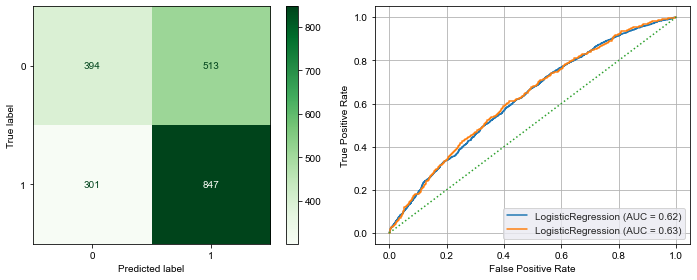

In [247]:
def evaluate_model(model, X_train, X_test, y_train, 
                   y_test, cmap='Greens', normalize=None,
                   classes=None,figsize=(10,4), graphs=False):
    
    """
    model :: classifier user desires to evaluate
    X_train :: X training data
    X_test :: X test data
    y_train :: y_train data
    y_test :: y_train data
    cmap :: color palette of confusion matrix
    normalize :: set to True if normalized confusion matrix is desired
    figsize :: desired plot size

    """
    
    # Print model accuracy
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')
    print('')
    
    # Option to show graphs
    if graphs == True:
        
        # Print classification report
        y_test_predict = model.predict(X_test)
        print(metrics.classification_report(y_test, y_test_predict,
                                            target_names=classes))

        # Plot confusion matrix
        fig,ax = plt.subplots(ncols=2,figsize=figsize)
        metrics.plot_confusion_matrix(model, X_test,y_test,cmap=cmap, 
                                      normalize=normalize,display_labels=classes,
                                      ax=ax[0])

        #Plot ROC curves
        with sns.axes_style("darkgrid"):
            curve = metrics.plot_roc_curve(model,X_train,y_train,ax=ax[1])
            curve2 = metrics.plot_roc_curve(model,X_test,y_test,ax=ax[1])
            curve.ax_.grid()
            curve.ax_.plot([0,1],[0,1],ls=':')
            fig.tight_layout()
            plt.show()

evaluate_model(model_log, X_train, X_test, y_train, 
                   y_test, graphs=True)

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.62460897 0.59645464 0.58350731 0.62108559 0.58455115]

Cross validation mean: 	60.20%
Training Accuracy: 60.39%
Test Accuracy: 60.39%

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       907
           1       0.62      0.74      0.68      1148

    accuracy                           0.60      2055
   macro avg       0.59      0.59      0.58      2055
weighted avg       0.60      0.60      0.59      2055



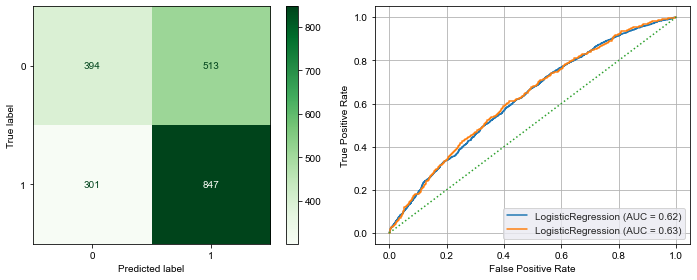

In [248]:
# Function to create models
def make_model(df, regressor=LogisticRegression, scale=False, graphs=False, dummy=False, cmap='Greens',
              slim=False, scaler=StandardScaler()):

    # Assigning X and y for train test split
    X = df.drop(['PlayerWin'], axis=1)
    y = df['PlayerWin']
    
    # Ensure target is integer format
    y=y.astype('int')

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=8)
    
    # Option to scale data with scaler type as parameter
    if scale==True:
        scaler = scaler
        X_train = pd.DataFrame(scaler.fit_transform(X_train))
        X_test = pd.DataFrame(scaler.transform(X_test))
    
    # Option to return dummy model
    if dummy == True:
        model_log = DummyClassifier(strategy='stratified')
        print('Using Dummy Model')
    else:
        model_log = regressor
    
    # Fit to X_train and y_train
    model_log.fit(X_train, y_train)
   
    # Print total number of samples
    total_samples = X_train.shape[0] + X_test.shape[0]
    print(f'Total number of samples: {total_samples}')
    print('------------------------------------------')
    
    # Option to suppress cross validation scores
    if slim == False:
        cross_val_check('Logistic Regression', model_log, X_train, y_train, X_test, y_test)
    
    evaluate_model(model_log, X_train, X_test, y_train, y_test, graphs=graphs, cmap=cmap)

make_model(model_df, scale=False, graphs=True, regressor=LogisticRegression())

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.6725756  0.68404588 0.65553236 0.66075157 0.66805846]

Cross validation mean: 	66.82%
Training Accuracy: 67.24%
Test Accuracy: 66.96%

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       907
           1       0.68      0.77      0.72      1148

    accuracy                           0.67      2055
   macro avg       0.67      0.66      0.66      2055
weighted avg       0.67      0.67      0.66      2055



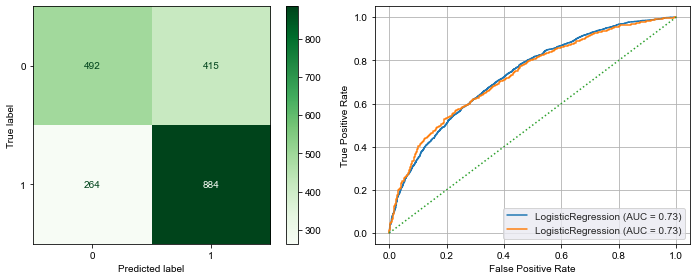

In [249]:
# Logistic regression with power transformer scaler
make_model(model_df, scale=True, graphs=True, regressor=LogisticRegression(), scaler=PowerTransformer())

# make_model(model_df, scale=True, graphs=True, regressor=LogisticRegression(), scaler=StandardScaler())
# make_model(model_df, scale=True, graphs=True, regressor=LogisticRegression(), scaler=RobustScaler())
# All features sorted power transformer 66.44 cross val, 67.96 test accuracy
# All features merged (not divided by 4) PT - 67.12 CV, 68.55 TA
# All features merged AVERAGE - PT - 67.03 CV, 68.55 TA
# Select featuers sorted 64.97 cv 67.30 TA
# Select features averaged 66.07 cv, 67.89 TA

Using Dummy Model
Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.50052138 0.50156413 0.51670146 0.47599165 0.52818372]

Cross validation mean: 	50.46%
Training Accuracy: 51.23%
Test Accuracy: 50.75%

              precision    recall  f1-score   support

           0       0.45      0.44      0.44       907
           1       0.56      0.57      0.56      1148

    accuracy                           0.51      2055
   macro avg       0.50      0.50      0.50      2055
weighted avg       0.51      0.51      0.51      2055



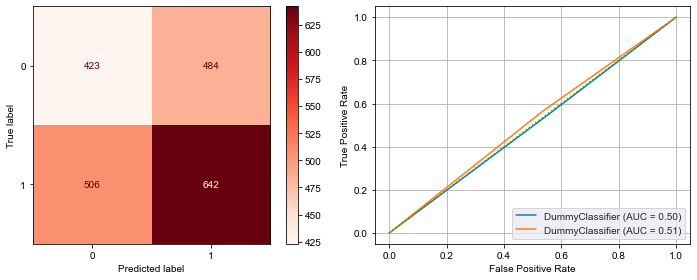

In [250]:
# Dummy model for comparison
make_model(model_df, scale=False, graphs=True, dummy=True, 
           cmap='Reds', regressor=LogisticRegression())

## Linear Regression Feature Importances

In [251]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Define and scale X train and test
scaler = PowerTransformer()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

# Create and fit logistic regressoin
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

# Print shape
print(X_train.shape)
print(X_test.shape)

(4792, 14)
(2055, 14)


Training Accuracy: 67.24%
Test Accuracy: 66.96%


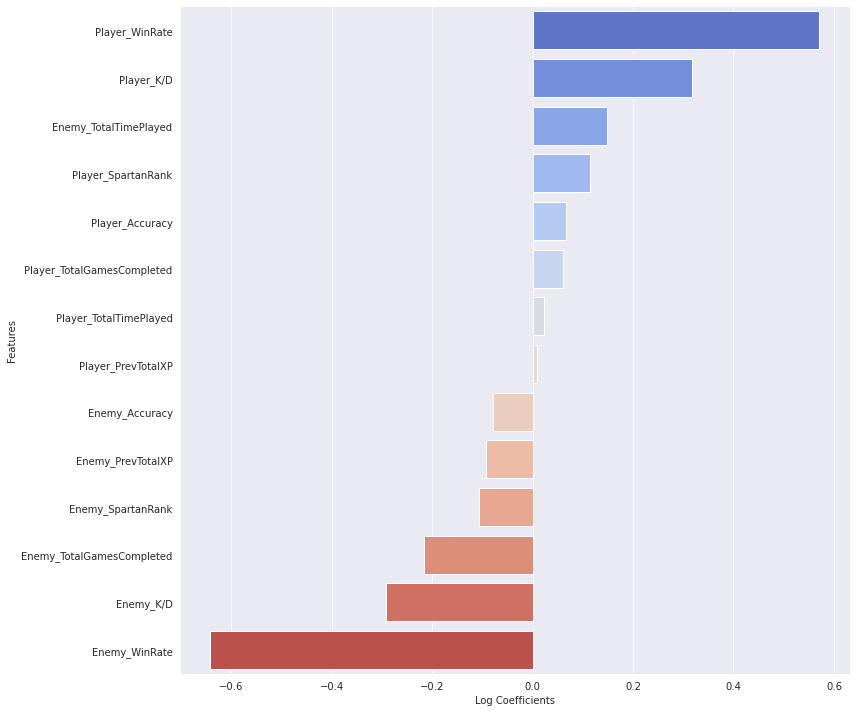

In [252]:
# Function to show model accuracy
def model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

# Uncomment line below to create images for presentation
# sns.set_context('talk')

# Function to plot logistic regression coefficients
def plot_coefficients(model, features, X_train, X_test, y_train=y_train, y_test=y_test, count=20):    
    
    # Create a list of coefficients
    coeffs = pd.Series(model.coef_.flatten(), index=features.columns).sort_values(ascending=False)
#     coeffs = coeffs[:20]
    top_coeffs = coeffs[:count]
    bottom_coeffs = coeffs[-count:]
    coeffs = top_coeffs.append(bottom_coeffs)
    
    # Display accuracy of newly trained model
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

    # Create coefficients plot
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(x=coeffs, y=coeffs.index, palette='coolwarm')
        ax.set(xlabel='Log Coefficients', ylabel='Features')
    
    # Save image
    plt.tight_layout()

    
plot_coefficients(model_log, features, X_train, X_test)

# Random Forest

In [254]:
# Make model_df from a copy of our dataframe up to this point
model_df = df.copy()

# Assign features and target
features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']

# Assigning X and y for train test split
X = features
y = target

# Ensure target is integer format
y = y.astype('int')

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Print shape
print(X_train.shape)
print(X_test.shape)

(4792, 14)
(2055, 14)


Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.6725756  0.66214807 0.64091858 0.65031315 0.66597077]

Cross validation mean: 	65.84%
Training Accuracy: 100.00%
Test Accuracy: 66.28%

              precision    recall  f1-score   support

           0       0.63      0.56      0.60       907
           1       0.68      0.74      0.71      1148

    accuracy                           0.66      2055
   macro avg       0.66      0.65      0.65      2055
weighted avg       0.66      0.66      0.66      2055



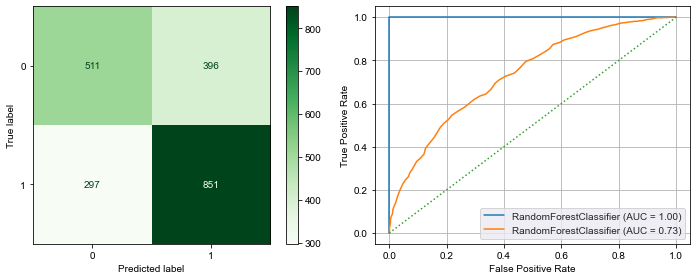

In [256]:
# Random forest not scaled
make_model(model_df, scale=False, graphs=True, regressor=RandomForestClassifier())
# all features sorted 65.88 CV, 67.11 test accuracy
# all features averaged 66.24 cv, 67.96 TA
# select features sort 67.30 TA

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.66736184 0.67153285 0.64926931 0.65240084 0.6691023 ]

Cross validation mean: 	66.19%
Training Accuracy: 100.00%
Test Accuracy: 67.01%

              precision    recall  f1-score   support

           0       0.65      0.55      0.60       907
           1       0.68      0.76      0.72      1148

    accuracy                           0.67      2055
   macro avg       0.67      0.66      0.66      2055
weighted avg       0.67      0.67      0.67      2055



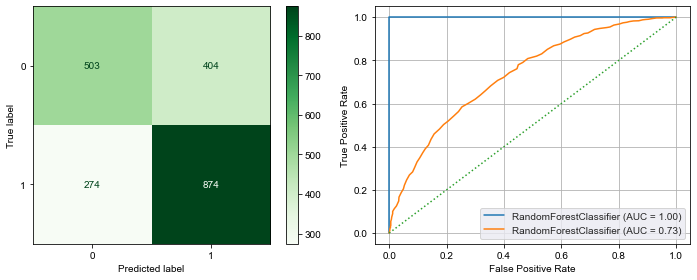

In [257]:
# Random forest with power transformer scale
make_model(model_df, scale=True, graphs=True, 
           regressor=RandomForestClassifier(), scaler=PowerTransformer())

# all featuers standard scaler 65.34 CV, 68.09 test accuracy
# all featuers added PT 64.89 CV, 68.29 test accuracy
# all features averaged PT 65.68 cv, 67.17 TA
# Select features sorted PT 65.85 CV 68.55 TA
# Select features merged PT 66.50 CV 68.42 TA

# Support Vector Machines

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.61001043 0.60062565 0.58872651 0.61377871 0.59394572]

Cross validation mean: 	60.14%
Training Accuracy: 60.35%
Test Accuracy: 60.15%

              precision    recall  f1-score   support

           0       0.60      0.29      0.39       907
           1       0.60      0.85      0.70      1148

    accuracy                           0.60      2055
   macro avg       0.60      0.57      0.55      2055
weighted avg       0.60      0.60      0.57      2055



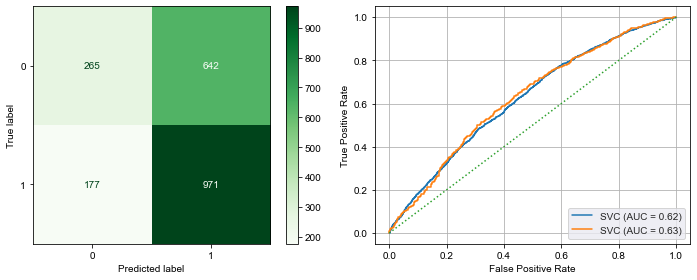

In [258]:
# SVM without scaling
make_model(model_df, scale=False, graphs=True, regressor=svm.SVC())

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.66527633 0.66214807 0.65344468 0.65135699 0.66597077]

Cross validation mean: 	65.96%
Training Accuracy: 70.72%
Test Accuracy: 65.40%

              precision    recall  f1-score   support

           0       0.64      0.50      0.56       907
           1       0.66      0.78      0.72      1148

    accuracy                           0.65      2055
   macro avg       0.65      0.64      0.64      2055
weighted avg       0.65      0.65      0.65      2055



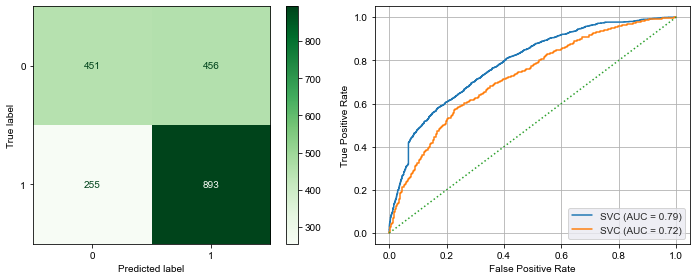

In [260]:
# SVM with standard scaler
# make_model(model_df, scale=True, graphs=True, regressor=svm.SVC(), scaler=StandardScaler())

# make_model(model_df, scale=True, graphs=True, regressor=svm.SVC(), scaler=RobustScaler())
make_model(model_df, scale=True, graphs=True, regressor=svm.SVC(), scaler=PowerTransformer())
# all features sorted PT 66.16 cv 67.76 ta
# all features merged PT averaged by 4 66.53 CV 68.68 TA
# sorted features 68.09 TA
# sorted merged standard scaler 67.04 TA

# XGBoost

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.64025026 0.65797706 0.63674322 0.61064718 0.66805846]

Cross validation mean: 	64.27%
Training Accuracy: 98.54%
Test Accuracy: 65.11%

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       907
           1       0.67      0.73      0.70      1148

    accuracy                           0.65      2055
   macro avg       0.65      0.64      0.64      2055
weighted avg       0.65      0.65      0.65      2055



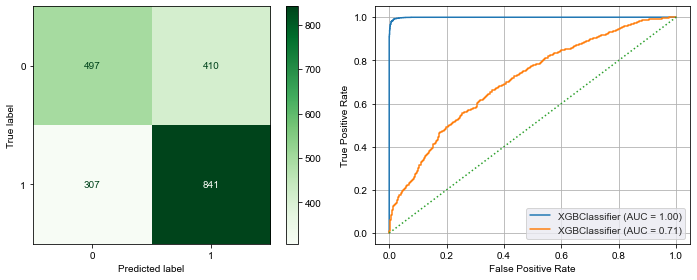

In [261]:
make_model(model_df, scale=False, graphs=True, regressor=XGBClassifier())
# no 68

Total number of samples: 6847
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.64337852 0.65901981 0.63674322 0.61064718 0.66805846]

Cross validation mean: 	64.36%
Training Accuracy: 98.54%
Test Accuracy: 65.11%

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       907
           1       0.67      0.73      0.70      1148

    accuracy                           0.65      2055
   macro avg       0.65      0.64      0.64      2055
weighted avg       0.65      0.65      0.65      2055



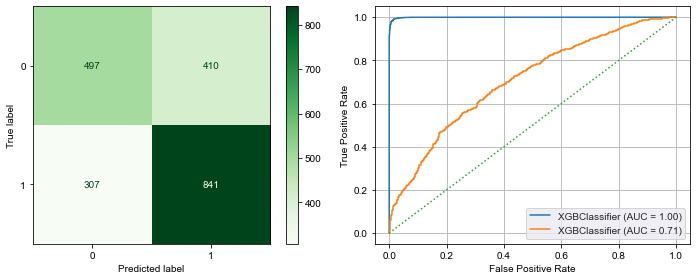

In [262]:
make_model(model_df, scale=True, graphs=True, regressor=XGBClassifier(), scaler=StandardScaler())
# make_model(model_df, scale=True, graphs=True, regressor=XGBClassifier(), scaler=RobustScaler())
# make_model(model_df, scale=True, graphs=True, regressor=XGBClassifier(), scaler=PowerTransformer())
# no 68

# K Nearest Neighbors

In [264]:
make_model(model_df, scale=False, graphs=True, regressor=KNeighborsClassifier())

NameError: name 'KNeighborsClassifier' is not defined

In [263]:
make_model(model_df, scale=True, graphs=True, 
           regressor=KNeighborsClassifier(), scaler=PowerTransformer())

NameError: name 'KNeighborsClassifier' is not defined

# Neural Networks

## MLP Classifier

Total number of samples: 5066
------------------------------------------
Logistic Regression Cross Validation Scores:
[0.66619718 0.68124118 0.67983075 0.64880113 0.65021157]

Cross validation mean: 	66.53%
Training Accuracy: 68.02%
Test Accuracy: 67.24%

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       685
           1       0.68      0.77      0.72       835

    accuracy                           0.67      1520
   macro avg       0.67      0.66      0.66      1520
weighted avg       0.67      0.67      0.67      1520



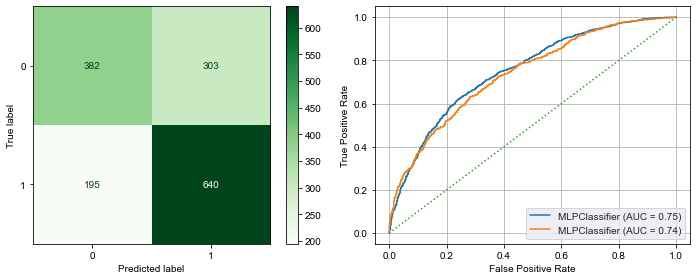

In [540]:
from sklearn.neural_network import MLPClassifier

make_model(model_df, scale=True, scaler=PowerTransformer(), graphs=True, 
           regressor=MLPClassifier(solver='lbfgs', alpha=1e-5, 
                                   hidden_layer_sizes=(5, 2), random_state=1))

## CNN Model

In [ ]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
X

In [ ]:
model_df = df.copy()

# Assigning X and y for train test split

features = model_df.drop(['PlayerWin'], axis=1)
target = model_df['PlayerWin']


X = features
Y = target

Y=Y.astype('int')

In [ ]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [ ]:

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=12, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=True)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))